In [1]:
import random
import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

**Вариант №4:** 

*Этап №1:*

Эллипс: $a = 0.4, b = 0.15, \alpha = \frac{\pi}{6}, x_0 = 0, y_0 = 0$

Эллипс: $a = 0.7, b = 0.5, \alpha = -\frac{\pi}{3}, x_0 = 0, y_0 = 0$

Эллипс: $a = 1, b = 1, \alpha = 0, x_0 = 0, y_0 = 0$

`Метод Resilient propagation.`

*Этап №2-3:*

$$x = \cos{(−3t^2 + 5t + 10)} , \; t \in [0, 2.5], h = 0.01$$

`Метод градиентного спуска` и `метод, предложенный Бройденом, Флетчером, Гольдфарбом и Шанно.`

In [2]:
a1, a2, a3 = 0.4, 0.7, 1.0
b1, b2, b3 = 0.15, 0.5, 1.0
alpha1, alpha2, alpha3 = math.pi / 6, -math.pi / 3, 0.0

In [3]:
def elipsis(a, b):
    gen = np.arange(0.0, 2* np.pi, 0.025)
    return np.array([a*np.cos(t) for t in gen]), np.array([b*np.sin(t) for t in gen])

In [4]:
def rotate_coords(x0, y0, alpha):
    gen = zip(x0, y0)
    func = lambda xy: (
        np.cos(alpha)*xy[0] - np.sin(alpha)*xy[1],
        np.sin(alpha)*xy[0] + np.cos(alpha)*xy[1]
    )
    transform = map(func, gen)
    result = tuple(map(np.array, zip(*transform)))
    
    return result[0], result[1]

### Реализация сети

In [5]:
class ActivationFunction:
    def __init__(self):
        pass
    def grad(self, X):
        pass
    def __call__(self, X):
        pass

In [6]:
class Purelin(ActivationFunction):
    def __call__(self, x):
        return x
    def grad(self, x):
        return 1.0

In [7]:
class Tansig(ActivationFunction):
    def __call__(self, x):
        return np.tanh(x)
    def grad(self, x):
        return 1.0 - self(x)**2.0

In [8]:
class Sigmoid(ActivationFunction):
    def __call__(self, x):
        ans = np.zeros(x.shape)
        mask = x < 0
        ans[mask] = np.exp(x[mask]) / (1.0 + np.exp(x[mask]))
        mask = x >= 0
        ans[mask] = 1.0 / (1.0 + np.exp(-x[mask]))
        return ans
    
    def grad(self, x):
        sigm = self(x)
        return sigm*(1.0 - sigm)

**Методы оптимизации:**

In [9]:
class OptimizeSolver:
    def __init__(self):
        self.graph = None
    def set_network(self, network):
        self.graph = network
    def __call__(self):
        pass

In [10]:
class GradientDescent(OptimizeSolver):
    def __init__(self, learn_rate=0.001):
        super().__init__()
        self.lr = learn_rate
        
    def __call__(self):
        for layer in self.graph:
            layer.W -= self.lr*layer.grad_W

In [11]:
class RProp(OptimizeSolver):
    def __init__(self, inf = 1e-6, sup = 50.0, n_neg=0.5, n_pos=1.2):
        super().__init__()
        self.last_grads = []
        self.last_deltas = []
        self.inf = inf
        self.sup = sup
        self.n_neg = n_neg
        self.n_pos = n_pos
        
    def set_network(self, network):
        super().set_network(network)
        # init last layers
        for layer in self.graph:
            self.last_grads.append(np.ones(layer.W.shape))
            self.last_deltas.append(np.random.random(layer.W.shape))
            
    def data_generator(self):
        return zip(self.graph, self.last_grads, self.last_deltas)
            
            
    def __call__(self):
        for layer, l_g, l_delta in self.data_generator():
            # compute new delta value inplace old value
            temp = l_delta[layer.grad_W*l_g > 0]
            l_delta[layer.grad_W*l_g > 0] = np.minimum(self.sup, temp*self.n_pos)
            temp = l_delta[layer.grad_W*l_g < 0]
            l_delta[layer.grad_W*l_g < 0] = np.maximum(self.inf, temp*self.n_neg)
            # update weights
            layer.W -= l_delta*np.sign(layer.grad_W)
            # update old gradient data with new values
            l_g[True] = layer.grad_W

In [12]:
class BFGS(OptimizeSolver):
    def __init__(self, learn_rate=0.001):
        super().__init__()
        self.last_H = None
        self.last_g = None
        self.last_W = None
        self.lr = learn_rate
        
    def set_network(self, network):
        super().set_network(network)
        self.set_weights()
        
    #init last values as zeros
    def set_weights(self):
        i = 0
        for layer in self.graph:
            i += layer.W.ravel().shape[0]
        
        self.last_W = np.random.random(i)
        self.last_g = np.zeros(i)
        self.last_H = np.eye(i)
    
    def __call__(self):
        grad_W = np.zeros(self.last_g.shape[0])
        W = np.zeros(self.last_W.shape[0])
        # store all weights in one matrix:
        n = 0
        for layer in self.graph:
            grad_W[n:n + layer.grad_W.ravel().shape[0]] = layer.grad_W.ravel()
            W[n:n + layer.W.ravel().shape[0]] = layer.W.ravel()
            n +=  layer.grad_W.ravel().shape[0]
        # g(k) - g(k - 1)
        y = grad_W - self.last_g
        # x(k) - x(k - 1)
        s = W - self.last_W
        
        p = 1.0/(y.dot(s))
        
        y = y.reshape(1, n)
        s = s.reshape(1, n)
        # compute H(k)
        H = (np.eye(n) - p*s.reshape(n, 1).dot(y))
        H = H.dot(self.last_H)
        H = H.dot(np.eye(n) - p*y.reshape(n, 1).dot(s))
        H += p*s.reshape(n, 1).dot(s)
        # update last values 
        self.last_H = H
        self.last_g = grad_W
        self.last_W = W
        # update weights vector
        orr = -self.lr * H.dot(grad_W.reshape(n, 1)).ravel()
        W = self.last_W + orr
        # update weights in layers
        n = 0
        for layer in self.graph:
            layer.W = W[n:n + layer.W.ravel().shape[0]].reshape(layer.W.shape)
            n += layer.W.ravel().shape[0]

In [13]:
class OutputLayer:
    def __init__(self):
        pass
    
    def __call__(self, X):
        pass
    
    def loss_grad(self, X, Y):
        pass
    
    def loss(self, X, Y):
        pass
    
    def classify_task(self, X):
        pass

In [14]:
class Softmax_with_CrossEntropy(OutputLayer): 
    def __call__(self, X):
        ans = np.exp(X)
        ans /= ans.sum(axis = 1).reshape(ans.shape[0], 1)
        return ans
    
    def loss(self, Y_out, Y_real):
        # loss - (log(q_i)*y_i).sum
        # we will take mean error for n examples
        return (-Y_real*np.log(Y_out)).sum(axis=1).mean()
    
    def loss_grad(self, Y_out, Y_real):
        return (Y_out - Y_real)
    
    def classify(self, X):
        return (X == X.max(axis=1)[:,None]).astype(np.int8)
    
    def classify_task(self, X):
        return (X  >= 0.5).astype(np.int8)

In [15]:
class Linear_with_MSE(OutputLayer):
    def __call__(self, X):
        # nothing to change
        return np.copy(X)
    
    def loss(self, Y_out, Y_real):
        # we will take mean error for all axes 
        return ((Y_out - Y_real)**2.0).mean()
    
    def loss_grad(self, Y_out, Y_real):
        return (Y_out - Y_real)
    
    def classify_task(self, X):
        return (X  >= 0.5).astype(np.int8)

**Нейронный слой**

In [16]:
# Fully conncted Layer with biases
class FullyConnectedLayer:
    def __init__(self, neuros = 64, activation = Sigmoid()):
        self.W = None
        self.X = None
        self.S = None
        self.activ_f = activation
        self.grad_W = None # current gradient for training
        self.neuros = neuros
    
    # weights initializer
    @staticmethod
    def weights_random_init(shape, limits):
        mult = limits[1] - limits[0]
        return np.random.random(shape)*mult + limits[0]
    
    # w_diap - diapazon of weights in init, solver - gradient method
    def compilation(self, prev_neuros, w_diap = (-5, 5)):
        # init weight  by random (+ 1 for bias)
        self.W = self.weights_random_init((prev_neuros + 1, self.neuros), w_diap)
        
        
    # forward step - just multiply matrix and store result
    def forward_step(self, X):
        # add column of ones for bias weights
        self.X = np.append(X, np.ones((X.shape[0], 1)), axis = 1)
        # compute net(X) function
        self.S = self.X.dot(self.W)
        # output - activation(net(X))
        return self.activ_f(self.S)
    
    # backward step - computes gradients of loss by each weights
    def backward_step(self, L_grad):
        L_grad *= self.activ_f.grad(self.S) # gradient from next layer
        next_grad = L_grad.dot(self.W[:-1].T) # gradient for next layer
        self.grad_W = np.zeros(self.W.shape) # init grad by (m, k) of 0.0
        # (dL/dw) - sum (avg) by all input data
        for i in range(self.X.shape[0]):
            # X[i] - (1, m), (dL/ds) - (1, k) =>
            # we need dot (m, 1) on (1, k) for get gradient by all weights of (m, k)
            self.grad_W += \
                self.X[i].reshape(
                    self.X.shape[1], 1
                ).dot(L_grad[i].reshape(1, L_grad.shape[1]))
        # self.opt_method(d_w) # update weights with some gradient optimize method
        return next_grad # return grad by funtion of next layer (dL/df)
    
    # Magic methods:
    def __str__(self):
        return "FullyConnected({})".format(self.neuros)
    
    def __repr__(self):
        return self.__str__()
    
    def __call__(self, X):
        return self.forward_step(X)

#### Нейронная сеть:

In [17]:
class NeuralNetwork:
    def __init__(self):
        self.graph = []
        self.solver = None
        self.output = None
    
    #  add layer to model
    def add(self, layer):
        self.graph.append(layer)
    
    # compile sequential network
    def compilation(self, solver, out_layer, data_dim):
        # data_dim - dimention of input vectors
        prev_neuros = data_dim
        # for each layer define Weights
        for layer in self.graph:
            layer.compilation(prev_neuros)
            prev_neuros = layer.neuros
        # set loss funstion with solver
        self.output = out_layer
        solver.set_network(self.graph) #init solver data
        self.solver = solver # set solver
    
    # train network
    def fit(self, X, Y, X_val=None, Y_val=None, steps=600, batch_size=1):
        hist = []
        # compute history if validation data exist
        if X_val is None and Y_val is None:
            hist = None 
        # reshape Y
        if len(Y.shape) == 1:
            Y = np.reshape(Y, (Y.shape[0], 1))
        # itterative weights updating
        for _ in tqdm(range(steps)):
            # for each batch in data do pass train pass in model
            for i in range(0, X.shape[0] - batch_size + 1, batch_size):
                # extract batch (X, Y)
                X_pass = X[i: i + batch_size]
                Y_pass = Y[i: i + batch_size]
                # do forward pass which compute intermideate values for update
                Y_out = self.forward_pass(X_pass)
                # compute gradient of last output
                Y_grad = self.output.loss_grad(Y_out, Y_pass)
                # compuite gradients for each layer in graph
                self.backward_pass(Y_grad)
                # solver has graph, call will update weights of layers
                self.solver()
            # append val loss to history if exist
            if hist is not None:
                hist.append(self.loss(X_val, Y_val))
        # return history of train
        return hist
    
    # forward pass - just matrix mults from start to end
    def forward_pass(self, X_pass):
        X_pass = np.copy(X_pass)
        for layer in self.graph:
            X_pass = layer(X_pass)
        
        return self.output(X_pass)
    
    # backward pass - backdirection move, which computes derivatives for layers
    def backward_pass(self, Y_grad):
        # getback direction
        back_direction = reversed(self.graph)
        for layer in back_direction:
            # compute gradient for next layer
            Y_grad = layer.backward_step(Y_grad)
            
    def classify(self, X):
        return self.output.classify(self(X))
    
    def classify_task(self, X):
        return self.output.classify_task(self(X))
    
    def loss(self, X, Y):
        return self.output.loss(self(X), Y)
            
    def __call__(self, X):
        if len(X.shape) == 1:
            X = X.reshape(1, X.shape[0])
        return self.forward_pass(X)
    
    def __str__(self):
        return "Neural Network"
    
    def __repr__(self):
        return self.__str__()

### Решение

***Этап №1***

Сгенерируем входную последовательность на основе заднного интервала и шага, а также перемешаем её:

In [18]:
def gen_line(a, b, alpha):
    points = rotate_coords(*elipsis(a, b), alpha)
    x = np.reshape(points[0], (points[0].shape[0], 1))
    y = np.reshape(points[1], (points[1].shape[0], 1))
    return np.hstack((x, y))

def create_dataset_classify(*args):
    tmp = np.zeros(len(args))
    tmp[0] = 1.0
    X = args[0]
    Y = np.zeros((X.shape[0], len(args)))
    Y[:] = tmp
    for i in range(1, len(args)):
        tmp[i - 1], tmp[i] = 0.0, 1.0
        X_cls = args[i]
        Y_cls = np.zeros((X_cls.shape[0], len(args)))
        Y_cls[:] = tmp
        X = np.append(X, X_cls, axis=0)
        Y = np.append(Y, Y_cls, axis=0)
    permut = permutation(len(X))
    return X[permut], Y[permut]

def assimetric_dataset_classify(data, nums):
    tmp = np.zeros(len(data))
    tmp[0] = 1.0
    permut = permutation(data[0].shape[0])[:nums[0]]
    X = data[0][permut]
    Y = np.zeros((len(permut), len(data)))
    Y[:] = tmp
    for i in range(1, len(data)):
        tmp[i - 1], tmp[i] = 0.0, 1.0
        permut = permutation(data[i].shape[0])[:nums[i]]
        X_cls = data[i][permut]
        Y_cls = np.zeros((len(permut), len(data)))
        Y_cls[:] = tmp
        X = np.append(X, X_cls, axis=0)
        Y = np.append(Y, Y_cls, axis=0)
    permut = permutation(len(X))
    return X[permut], Y[permut]

In [19]:
cls1 = gen_line(a1, b1, alpha1)
cls2 = gen_line(a2, b2, alpha2)
cls3 = gen_line(a3, b3, alpha3)
X, Y = assimetric_dataset_classify((cls1, cls2, cls3), (60, 100, 120))

Разделим множество на обучающее, контрольное, тестовое:

In [20]:
train_p = 0.7
valid_p = 0.2
test_p = 0.1

In [21]:
size_train = int(train_p * X.shape[0])
bound_valid = size_train + int(valid_p * X.shape[0])

X_train, Y_train = X[:size_train], Y[:size_train]
X_valid, Y_valid = X[size_train:bound_valid], Y[size_train:bound_valid]
X_test, Y_test = X[bound_valid:], Y[bound_valid:]


Функция для отрисовки данных:

In [22]:
def plot_data(set_X, set_Y):
    plt.figure(figsize=(16, 10))
    tmp_x = list(set_X)
    tmp_y = list(set_Y)
    markers = ['.', 's', '^']
    texts = ["Train", "Test", "Validation"]

    for x, y, m, t in zip(tmp_x, tmp_y, markers, texts):
        x_1 = x[y[:, 0] == 1]
        x_2 = x[y[:, 1] == 1]
        x_3 = x[y[:, 2] == 1]
        plt.scatter(x_1.T[0], x_1.T[1], marker=m, color='b', linewidths=2, label=t)
        plt.scatter(x_2.T[0], x_2.T[1], marker=m, color='g', linewidths=2)   
        plt.scatter(x_3.T[0], x_3.T[1], marker=m, color='r', linewidths=2) 
        
    plt.legend()
    plt.title("Данные")

Отрисуем полученные множества:

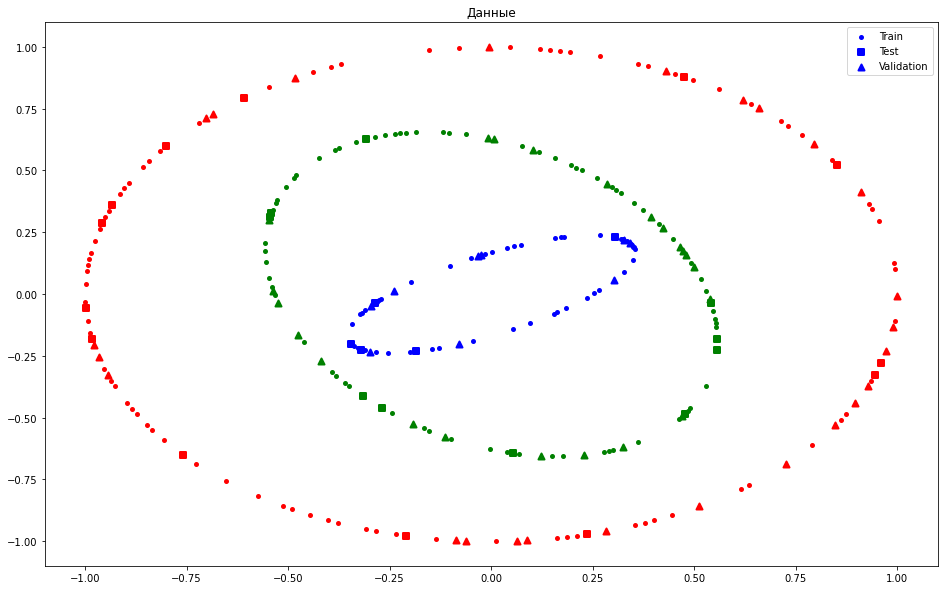

In [23]:
plot_data([X_train, X_test, X_valid], [Y_train, Y_test, Y_valid])

Функция для отрисовки классификации на тестовых данных:

In [24]:
def plot_test_classify(X, Y, X_test, Y_out):
    plt.figure(figsize=(15, 9))

    x_1 = X_test[Y_out[:, 0] == 1]
    x_2 = X_test[Y_out[:, 1] == 1]
    x_3 = X_test[Y_out[:, 2] == 1]
    x_4 = X_test[(Y_out[:, 0] == 0) & (Y_out[:, 1] == 0) & (Y_out[:, 2] == 0)]
    plt.scatter(x_1.T[0], x_1.T[1], color='b', linewidths=2, label="Predicted")
    plt.scatter(x_2.T[0], x_2.T[1], color='g', linewidths=2)   
    plt.scatter(x_3.T[0], x_3.T[1], color='r', linewidths=2)
    plt.scatter(x_4.T[0], x_4.T[1], marker='^', color='black', linewidths=2, label="Not predicted")


    x_1 = X[Y[:, 0] == 1]
    x_2 = X[Y[:, 1] == 1]
    x_3 = X[Y[:, 2] == 1]
    plt.scatter(x_1.T[0], x_1.T[1], color='b', s=2, label="Real")
    plt.scatter(x_2.T[0], x_2.T[1], color='g', s=2)   
    plt.scatter(x_3.T[0], x_3.T[1], color='r', s=2) 

    plt.legend()
    plt.title("Результат классификации")

Функция отрисовки процесса обучения по шагам:

In [25]:
def plot_history(hist):
    plt.figure(figsize=(15, 7))
    plt.plot(np.arange(len(hist)), hist, label="Validation error")
    plt.xlabel("step")
    plt.ylabel("MSE")
    plt.title("Функция потерь при обучении")
    plt.grid()
    plt.legend()

Функция классификации и отрисовки результата на заданном прямоуголькнике с 3 классами:


***Вариант №1:***

Создадим и скомпилируем нейронную сеть из 2-ух слоев с оптимизатором *Resilient Propogation* и обучим ее классифицировать объекты на тренировочных данных. Выход сети - *Sigmoid*, функция потерь - *MSE*.

In [26]:
model = NeuralNetwork()
model.add(FullyConnectedLayer(neuros=20, activation=Sigmoid()))
model.add(FullyConnectedLayer(neuros=3, activation=Sigmoid()))

model.compilation(solver=RProp(), out_layer=Linear_with_MSE(), data_dim=2)
hist = model.fit(X_train, Y_train, X_valid, Y_valid, 40, X_train.shape[0])

100%|█████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 483.22it/s]


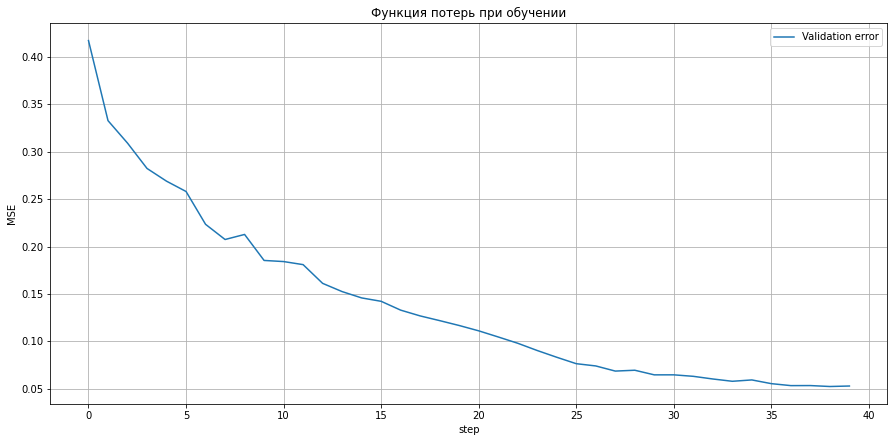

In [27]:
plot_history(hist)

In [28]:
Y_out = model.classify_task(X_test)
print("Ошибка на тестовой выборке:", model.loss(X_test, Y_test))

Ошибка на тестовой выборке: 0.0387226724815743


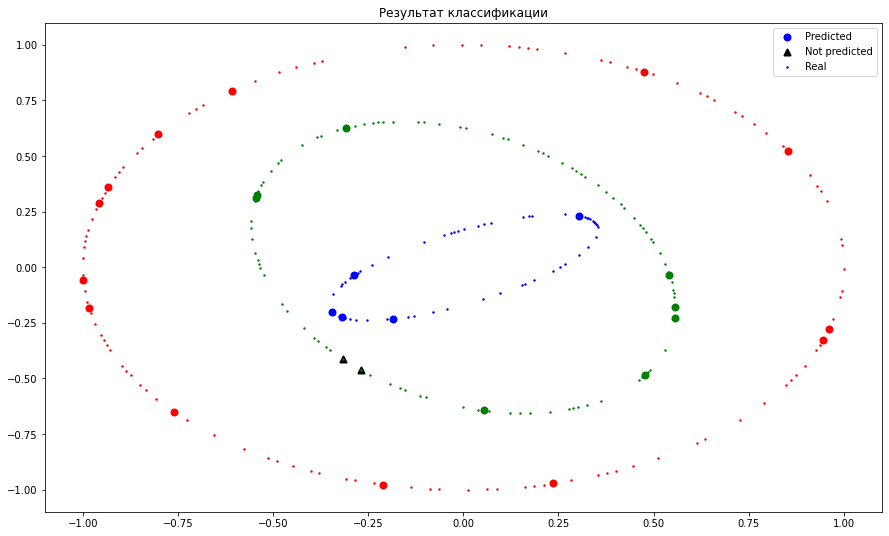

In [29]:
plot_test_classify(X, Y, X_test, Y_out)

***Вариант №2:***

Создадим и скомпилируем нейронную сеть из 2-ух слоев с оптимизатором *Resilient Propogation* и обучим ее классифицировать объекты на тренировочных данных. Выход сети - *Softmax*, функция потерь - *Cross Entropy*.

In [30]:
model = NeuralNetwork()
model.add(FullyConnectedLayer(neuros=20, activation=Tansig()))
model.add(FullyConnectedLayer(neuros=3, activation=Purelin())) # for softmax use linear output

model.compilation(solver=RProp(), out_layer=Softmax_with_CrossEntropy(), data_dim=2)
hist = model.fit(X_train, Y_train, X_valid, Y_valid, 40, X_train.shape[0])

100%|█████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 542.00it/s]


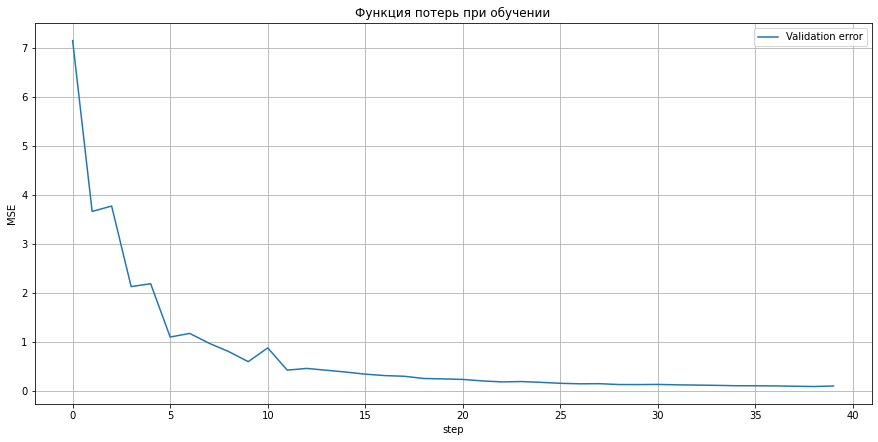

In [31]:
plot_history(hist)

In [32]:
Y_out = model.classify_task(X_test)
print("Ошибка на тестовой выборке:", model.loss(X_test, Y_test))

Ошибка на тестовой выборке: 0.05644977180067374


***Этапы №2-3***

In [33]:
interval = (0, 3.5)
step_h = 0.01

In [34]:
def func_t(t):
    return np.sin(np.sin(t)*t*t + 5*t)

Сгенерируем и перемешаем входную последовательность на основе заднного интервала и шага:

In [35]:
x = np.arange(*interval, step_h)
y = func_t(x)

permut = permutation(len(x))
x, y = x[permut].reshape(x.shape[0], 1), y[permut].reshape(y.shape[0], 1)

Разделим выборку на обучающую и контрольную:

In [36]:
train_p = 0.9
valid_p = 0.1

In [37]:
size_train = int(train_p * x.shape[0])

X_train, Y_train = x[:size_train], y[:size_train]
X_valid, Y_valid = x[size_train:], y[size_train:]

Зададим две нейронных сети, каждая из которых будет иметь по два слоя. Перввая будет в качестве решателя использовать `градиентный спуск`, а вторая `метод, предложенный Бройденом, Флетчером, Гольдфарбом и Шанно`. В качестве выхода будет использоваться *линейная функция активации* с функцией потерь - *MSE*.

In [38]:
model1 = NeuralNetwork()
model1.add(FullyConnectedLayer(neuros=10, activation=Tansig()))
model1.add(FullyConnectedLayer(neuros=1, activation=Purelin()))
model1.compilation(solver=GradientDescent(learn_rate=0.00005), out_layer=Linear_with_MSE(), data_dim=1)

model2 = NeuralNetwork()
model2.add(FullyConnectedLayer(neuros=10, activation=Tansig()))
model2.add(FullyConnectedLayer(neuros=1, activation=Purelin()))
model2.compilation(solver=BFGS(learn_rate=0.000005), out_layer=Linear_with_MSE(), data_dim=1)

Обучение сетей.

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 451.68it/s]


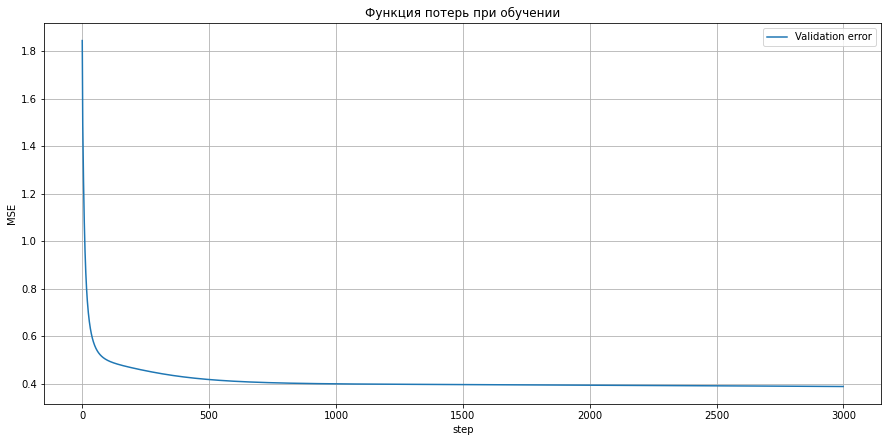

In [39]:
hist = model1.fit(X_train, Y_train, X_valid, Y_valid, 3000, X_train.shape[0])
plot_history(hist)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 430.31it/s]


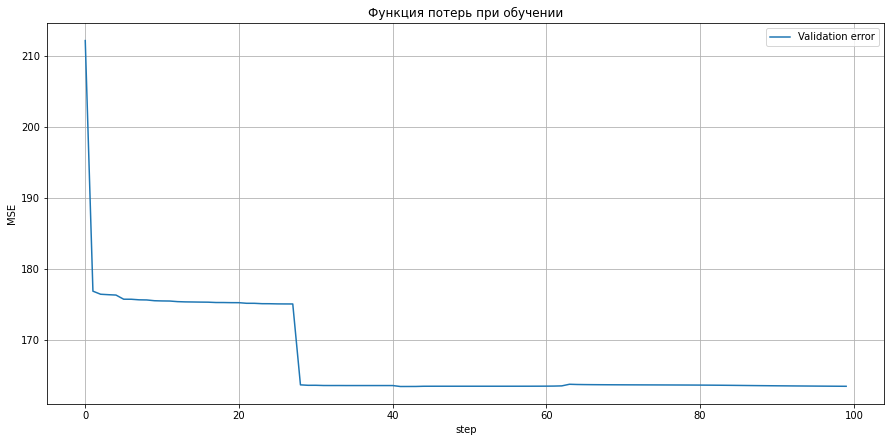

In [40]:
hist = model2.fit(X_train, Y_train, X_valid, Y_valid, 100, X_train.shape[0])
plot_history(hist)

Результаты обучения:

In [41]:
Y_gd_train = model1(X_train)
Y_gd_valid = model1(X_valid)

Y_bfgs_train = model2(X_train)
Y_bfgs_valid = model2(X_valid)

Ошибка обучения градиентного спуска: 0.3106083821380424
Ошибка обучения BFGS: 146.08300389761618


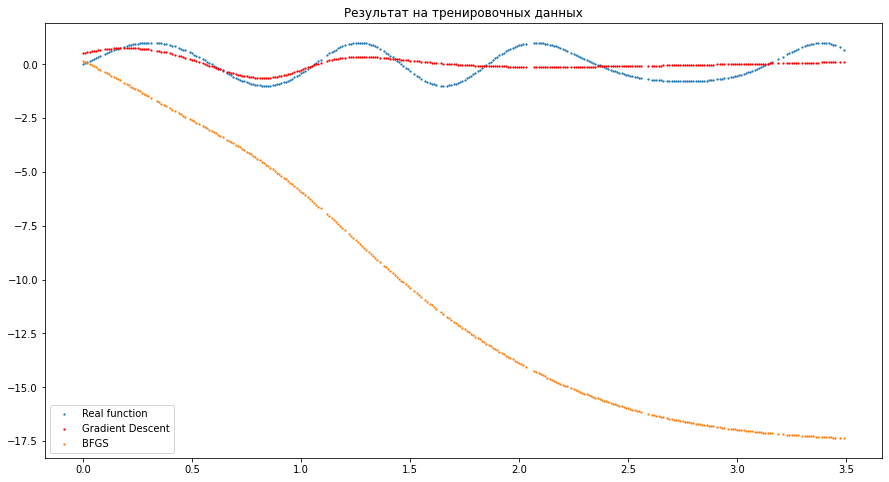

In [42]:
plt.figure(figsize=(15, 8))
plt.scatter(X_train, Y_train, s=1.5, label='Real function')
plt.scatter(X_train, Y_gd_train, s=1.5, label='Gradient Descent', color='red')
plt.scatter(X_train, Y_bfgs_train, s=1.5, label='BFGS')
plt.legend()
plt.title("Результат на тренировочных данных")

print("Ошибка обучения градиентного спуска:", model1.loss(X_train, Y_train))
print("Ошибка обучения BFGS:", model2.loss(X_train, Y_train))

Ошибка обучения градиентного спуска: 0.3882834943434438
Ошибка обучения BFGS: 163.455869926231


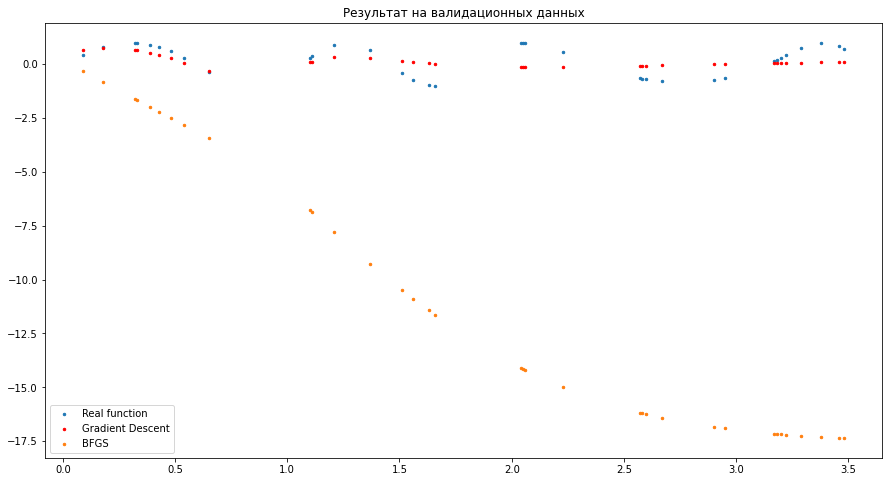

In [43]:
plt.figure(figsize=(15, 8))
plt.scatter(X_valid, Y_valid, s=6, label='Real function')
plt.scatter(X_valid, Y_gd_valid, s=6, label='Gradient Descent', color='red')
plt.scatter(X_valid, Y_bfgs_valid, s=6, label='BFGS')
plt.legend()
plt.title("Результат на валидационных данных")

print("Ошибка обучения градиентного спуска:", model1.loss(X_valid, Y_valid))
print("Ошибка обучения BFGS:", model2.loss(X_valid, Y_valid))